# Quantum Stock Picking and Quantum Portfolio Optimization


## Introduction

This assignment will shows how we can use mean-variance optimization to pick stocks for a problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This notebook shows how to use the Variational Quantum Eigensolver (VQE) to find the optimal solution for a given set of parameters.

Experiments on real quantum hardware for this problem are reported for instance in the following paper:
<br>
[Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.](https://arxiv.org/abs/1907.04769)

Note: We are not using CVaR as a portfolio statistic here, rather as a heuristic in our VQE procedure, curious students are encouraged to read the paper above.

#### To Students: Complete the following sections labeled todo

In [1]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider, YahooDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.utils import algorithm_globals

import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas
import pandas as pd
import seaborn as sns

def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [2]:
#global random seed used throuhgout
seed = 42

In [3]:
# Generate expected return and covariance matrix from (random) time-series

#Todo pick candidate stocks, 3-8 are recommended, stick to 4 if you're going to submit a real quantum experiment to IBM's cloud:

stocks = ['ACN','NVDA','GOOGL','MSFT','BABA']

# Here are some quantum themed stocks :) 
# ['IBM','AMD','ACN','NVDA','GOOGL','MSFT','AMZN','MU','BABA']
# Feel free to pick any in this list or beyond
    
num_assets = len(stocks)

#IBM has done us a favour and provided a cute data provider they designed.
data = YahooDataProvider(tickers=stocks,
                         start=pandas.Timestamp(2015, 1, 1),
                         end=pandas.Timestamp.now(),
                        )
data.run()

# Here we pull apart the IBM qiskit_finance.data_provider internals to retreive our data and format as a pandas DataFrame
df = pandas.DataFrame({data._tickers[tidx]:data._data[tidx] for tidx in range(len(data._tickers))})

# Provided by IBM
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [4]:
q = 0.50                   #  risk appetite 
budget = num_assets  //2   #  stocks to allocate
penalty = num_assets       #  set parameter to scale the budget penalty term
bounds = None              #  Allocation percent: None: 100%

portfolio = PortfolioOptimization(expected_returns=mu,
                                  covariances=sigma,
                                  risk_factor=q,
                                  budget=budget,
                                  bounds=bounds,
                                 )
qp = portfolio.to_quadratic_program()
qp


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000975501874 x_0 - 0.002807268546 x_1 - 0.001106358319 x_2
      - 0.001341392488 x_3 - 0.000382718201 x_4 + [ 0.000223331413 x_0^2
      + 0.000393904831 x_0*x_1 + 0.000291100013 x_0*x_2 + 0.000339333477 x_0*x_3
      + 0.000237850739 x_0*x_4 + 0.000810763513 x_1^2 + 0.000486080641 x_1*x_2
      + 0.000565082481 x_1*x_3 + 0.000502141912 x_1*x_4 + 0.000278936102 x_2^2
      + 0.000412038526 x_2*x_3 + 0.000320962435 x_2*x_4 + 0.000288344709 x_3^2
      + 0.000326389964 x_3*x_4 + 0.000474631516 x_4^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 + x_4 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End

## Solution using VQE
We can now use the Variational Quantum Eigensolver (VQE) to solve the problem. We will specify the optimizer and variational form to be used.

Note: You can switch to different backends by providing the name of backend.

In [5]:
algorithm_globals.random_seed = seed + 1
backend = Aer.get_backend('statevector_simulator')


cobyla = COBYLA()
cobyla.set_options(maxiter=500)

ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')

quantum_instance = QuantumInstance(backend=backend,
                                   seed_simulator=seed,
                                   seed_transpiler=seed)

vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)

result = vqe.solve(qp)


# print(result.fval)
print_result(result)

/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


Optimal: selection [0. 1. 0. 1. 0.], value -0.0033

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 1]	-0.0012		0.3267
[0 1 1 0 0]	-0.0031		0.2393
[0 0 1 0 1]	-0.0010		0.1704
[0 1 0 1 0]	-0.0033		0.1423
[0 0 1 1 0]	-0.0020		0.0915
[0 1 0 0 1]	-0.0023		0.0296
[1 1 0 0 0]	-0.0031		0.0001
[1 0 0 0 1]	-0.0009		0.0000
[1 0 0 1 1]	1.0078		0.0000
[1 0 0 1 0]	-0.0019		0.0000
[0 0 0 1 0]	1.0084		0.0000
[1 1 0 1 1]	4.0349		0.0000
[0 1 0 0 0]	1.0072		0.0000
[1 1 0 0 1]	1.0067		0.0000
[1 1 1 0 0]	1.0059		0.0000
[1 1 0 1 0]	1.0058		0.0000
[0 0 0 0 1]	1.0094		0.0000
[0 1 1 0 1]	1.0067		0.0000
[1 0 0 0 0]	1.0087		0.0000
[0 0 1 1 1]	1.0078		0.0000
[1 0 1 1 1]	4.0361		0.0000
[0 1 1 1 0]	1.0058		0.0000
[0 0 0 0 0]	4.0384		0.0000
[1 1 1 0 1]	4.0351		0.0000
[1 0 1 1 0]	1.0071		0.0000
[0 0 1 0 0]	1.0086		0.0000
[1 0 1 0 0]	-0.0017		0.0000
[0 1 0 1 1]	1.0065		0.0000
[0 1 1 1 1]	4.0349		0.0000
[1 1 1 1 1]	9.0827		0.

In [6]:
selected_stocks = list(np.array(stocks)[result.x.astype('bool')])
print(f"Stocks from our Qunatum Stock Picking algorthm selected: {selected_stocks}")

Stocks from our Qunatum Stock Picking algorthm selected: ['NVDA', 'MSFT']


### Student todo, complete an equity curve, CAGR and IR comparison for the a portfolio of all the stocks you selected for optimization compared to one which your Quantum Stock picker put together

hints:


df[selected_stocks] contains a data frame with your stock pick prices.   
df is the full list of stocks you started with.

IR selection: 1.614
IR all: 1.361 

CAGR selection: 59.93%
CAGR all: 35.38%


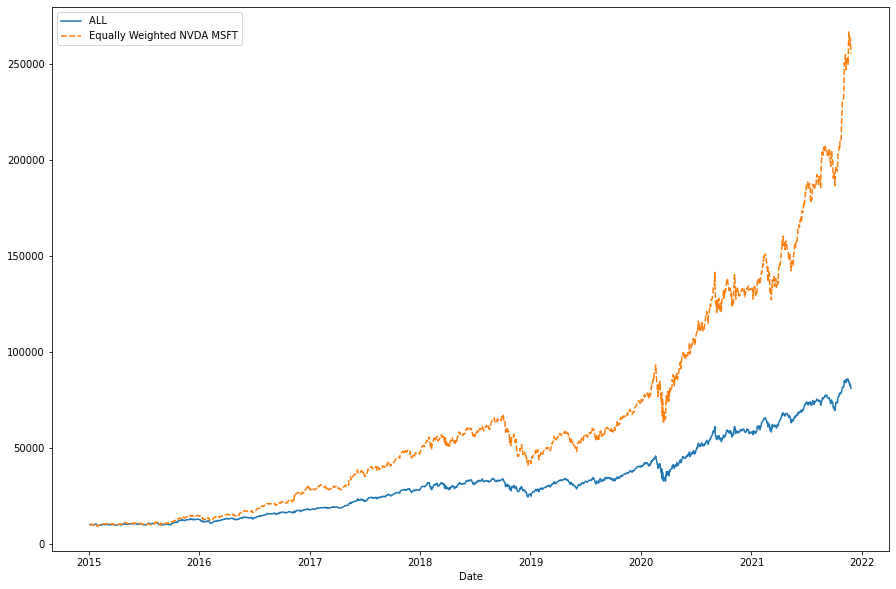

In [7]:
p_all = df.pct_change().mean(axis=1)
p_all.name = "ALL "

p_01 = df.loc[:, selected_stocks].pct_change().mean(axis=1)
p_01.name = f"Equally Weighted {' '.join(selected_stocks)}"
n = len(df)

print(f"IR selection: {p_01.mean() / p_01.std() * (252) ** (0.5):.3f}")
print(f"IR all: {p_all.mean() / p_all.std() * (252) ** (0.5):.3f} \n")


print(f"CAGR selection: {(p_01.add(1).prod() ** (252/n) - 1) * 100:.2f}%")
print(f"CAGR all: {(p_all.add(1).prod() ** (252/n) - 1) * 100:.2f}%")

fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(data=pd.concat([p_all.add(1).cumprod(),
                             p_01.add(1).cumprod()], axis=1) * 10_000,)
fig.show()

# (Optional) For Advanced Students:

## Here we will make some modifications to do portfolio optimization


This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{-j, +k\}^n$ denotes the vector of binary decision variables, which indicate the relative allocation to assign. 
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to allocate exactly $B$ relative amounts of asset.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This rest of this notebook shows how to use the Variational Quantum Eigensolver (VQE) an optimal solution for a given set of parameters.

In [8]:
q = 0.50                   #  risk appetite 
budget = num_assets        #  Units to allocate
penalty = num_assets //2   #  set parameter to scale the budget penalty term
bounds = [(-1, 2)]*num_assets  #  Allocation units, can be negative or positive


portfolio = PortfolioOptimization(expected_returns=mu,
                                  covariances=sigma,
                                  risk_factor=q,
                                  budget=budget,
                                  bounds=bounds)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000975501874 x_0 - 0.002807268546 x_1 - 0.001106358319 x_2
      - 0.001341392488 x_3 - 0.000382718201 x_4 + [ 0.000223331413 x_0^2
      + 0.000393904831 x_0*x_1 + 0.000291100013 x_0*x_2 + 0.000339333477 x_0*x_3
      + 0.000237850739 x_0*x_4 + 0.000810763513 x_1^2 + 0.000486080641 x_1*x_2
      + 0.000565082481 x_1*x_3 + 0.000502141912 x_1*x_4 + 0.000278936102 x_2^2
      + 0.000412038526 x_2*x_3 + 0.000320962435 x_2*x_4 + 0.000288344709 x_3^2
      + 0.000326389964 x_3*x_4 + 0.000474631516 x_4^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 + x_4 = 5

Bounds
 -1 <= x_0 <= 2
 -1 <= x_1 <= 2
 -1 <= x_2 <= 2
 -1 <= x_3 <= 2
 -1 <= x_4 <= 2

Generals
 x_0 x_1 x_2 x_3 x_4
End

In [9]:
algorithm_globals.random_seed = seed + 1
#algorithm_globals.massive = True
backend = Aer.get_backend('statevector_simulator')


cobyla = COBYLA()
cobyla.set_options(maxiter=500)

ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)

result = vqe.solve(qp)

/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",
/opt/conda/lib/python3.8/site-packages/qiskit_optimization/algorithms/optimization_algorithm.py:141: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


In [10]:
allocations = pandas.DataFrame({f"{stocks[tidx]}":result.x[tidx] for tidx in range(len(stocks))},index=['Allocation'])

In [11]:
allocations

,ACN,NVDA,GOOGL,MSFT,BABA
Allocation,2.0,2.0,0.0,2.0,-1.0


### Student todo, complete an equity curve, CAGR and IR comparison for the a portfolio of all the stocks you selected for optimization compared to one which your Quantum Portfolio Optimzer put together.

hints:


The variable allocations contains a DataFrame with your relative stock allocations.   
df is the full list of stocks you started with.

IR modified optimization: 1.667
IR selection: 1.614
IR all: 1.361 

CAGR modified optimization: 57.17%
CAGR selection: 59.93%
CAGR all: 35.38%


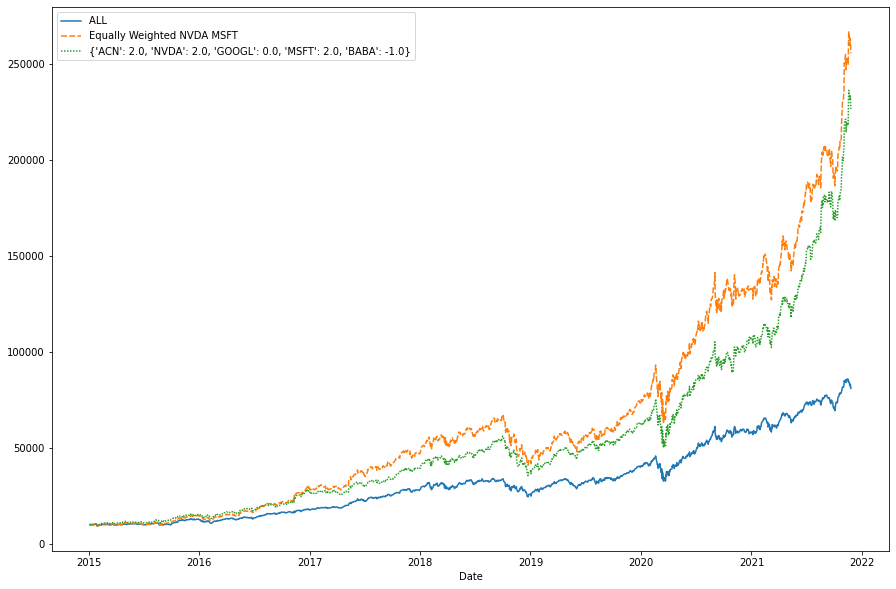

In [46]:
p_02 = df.loc[:, allocations.columns].pct_change().multiply(allocations.values, axis=1).mean(axis=1)
p_02.name = f"{str(allocations.to_dict(orient='records')[0])}"
n = len(df)

print(f"IR modified optimization: {p_02.mean() / p_02.std() * (252) ** (0.5):.3f}")
print(f"IR selection: {p_01.mean() / p_01.std() * (252) ** (0.5):.3f}")
print(f"IR all: {p_all.mean() / p_all.std() * (252) ** (0.5):.3f} \n")

print(f"CAGR modified optimization: {(p_02.add(1).prod() ** (252/n) - 1) * 100:.2f}%")
print(f"CAGR selection: {(p_01.add(1).prod() ** (252/n) - 1) * 100:.2f}%")
print(f"CAGR all: {(p_all.add(1).prod() ** (252/n) - 1) * 100:.2f}%")

fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(data=pd.concat([p_all.add(1).cumprod(),
                             p_01.add(1).cumprod(),
                             p_02.add(1).cumprod()], axis=1) * 10_000,)
fig.show()